<h4>Problem Statement:</h4> 
Classify breast cancer tumors into malignant or benign groups

The problem is a <b>supervised binary classification problem </b>

The model produced could be used in a production setting or as part of an ensemble model to flag patients who are likely to have cancer. We want to minimize rate of false negatives in this case and so I will look at metrics such as precision, recall and AUROC.


<h4>Import libraries and change jupyter settings

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn import tree, ensemble, svm
from sklearn.metrics import accuracy_score

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from sklearn.utils.multiclass import unique_labels
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold



In [2]:
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
data = pd.read_csv('test/Data_to_applicants.csv')

In [5]:
data.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842934,19.772,11.336,134.599,1096.771,0.067,0.326,0.385,0.221,0.217,0.099,1.243,0.979,9.368,168.133,0.024,0.077,0.017,-0.020,-0.004,0.035,27.839,19.029,202.212,2211.972,0.212,0.737,0.781,0.287,0.466,0.133,M
1,843149,22.601,19.453,145.467,1452.768,0.099,0.052,0.042,0.151,0.191,0.140,0.692,0.809,3.642,81.215,0.069,-0.004,0.038,-0.043,0.133,-0.027,27.368,25.600,173.949,2143.103,0.137,0.282,0.311,0.184,0.302,0.196,M
2,84301535,21.507,23.214,142.380,1317.998,0.111,0.266,0.241,0.197,0.166,0.081,0.779,0.852,4.982,103.117,-0.054,0.009,0.071,-0.038,-0.023,0.064,25.882,28.073,167.074,1872.370,0.119,0.395,0.459,0.300,0.361,0.126,M
3,84348933,12.505,22.374,85.098,423.055,0.275,0.252,0.280,0.107,0.250,0.120,0.524,1.282,3.784,29.843,-0.007,0.111,0.062,0.082,0.014,0.001,16.386,28.946,108.286,622.059,0.168,0.971,0.728,0.266,0.737,0.349,M
4,84359034,22.227,15.690,148.024,1420.916,-0.032,0.261,0.230,0.120,0.120,0.087,0.793,0.824,5.970,103.499,0.033,0.087,0.074,0.116,0.052,-0.079,24.687,18.287,166.754,1725.556,0.161,0.234,0.464,0.336,0.218,0.107,M


<b>Features and what they mean:</b>

id 

radius - mean of distances from center to points on the perimeter

texture - standard deviation of gray-scale values

perimeter 

area 

smoothness - local variation in radius lengths

compactness - perimeter^2 / area - 1.0

concavity - severity of concave portions of the contour

concave points - number of concave portions of the contour

symmetry 

fractal dimension - "coastline approximation" - 1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            568 non-null float64
compactness_mean           568 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     568 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    568 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               568 non-null float64
concave points_se          568 no

All values are float apart from the diagnosis feature which I will convert to a binary value later. There seem to be some null values which we will handle later using an imputer. 

In [7]:
data.diagnosis.value_counts()/len(data)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

Here I observer that we have 62% benign and 37% malignant samples. So, there is some class imbalance but its not too much. If the model performs poorly I can try some strategies such as over-sampling or under-sampling to mitigate the effects of the class imbalance.

In [8]:
data[data.diagnosis == 'M'].describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,2.120000e+02,212.000000,212.000000,212.000000,212.000000,211.000000,211.000000,212.000000,212.000000,212.000000,211.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,211.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,211.000000,212.000000,212.000000,212.000000,212.000000
mean,3.681868e+07,19.132151,23.668759,126.399057,1071.907363,0.117844,0.159114,0.174637,0.096316,0.206557,0.067166,0.663425,1.328321,4.732099,79.627245,0.009580,0.034717,0.044986,0.013607,0.024901,0.004542,23.156467,32.124175,154.877061,1558.256778,0.158458,0.407583,0.495132,0.197462,0.349344,0.098542
std,1.378965e+08,3.510373,4.144795,23.942743,403.111485,0.057174,0.076487,0.097346,0.066464,0.059681,0.048951,0.382564,0.533413,2.814074,67.225590,0.048738,0.052040,0.059526,0.051831,0.050883,0.048436,4.691402,5.960002,32.274206,655.139828,0.054028,0.192018,0.202791,0.071080,0.094427,0.058019
min,9.302000e+03,11.978000,11.336000,78.789000,396.197000,-0.032000,0.016000,-0.102000,-0.077000,-0.013000,-0.056000,0.120000,0.317000,1.434000,15.307000,-0.116000,-0.130000,-0.114000,-0.126000,-0.102000,-0.126000,14.133000,18.287000,93.263000,556.699000,0.023000,0.018000,0.020000,-0.035000,0.143000,-0.043000
25%,8.619770e+05,16.510500,21.176750,108.181250,772.730000,0.079500,0.105500,0.115500,0.044500,0.166000,0.030000,0.411500,0.977000,2.960750,39.218750,-0.026250,0.003750,0.003750,-0.018500,-0.006000,-0.029000,19.471750,28.200750,130.706250,1063.032000,0.124000,0.272500,0.348750,0.141750,0.283000,0.062000
50%,8.959985e+05,18.972500,23.527000,125.075500,1021.106000,0.116000,0.152000,0.168000,0.098000,0.210500,0.068000,0.591500,1.233500,4.067500,64.044000,0.013000,0.034000,0.043000,0.015000,0.025000,0.005000,22.572500,31.701500,151.187000,1427.567000,0.158000,0.379000,0.461000,0.198000,0.333000,0.098000
75%,8.911922e+06,21.437000,26.023750,142.375500,1318.808500,0.152000,0.209000,0.230000,0.132250,0.245000,0.100500,0.824250,1.564500,5.740250,103.005250,0.040250,0.073000,0.079000,0.044500,0.058000,0.036000,26.113500,35.735500,175.107500,1876.485500,0.193000,0.492500,0.613750,0.244250,0.403250,0.129250
max,9.112968e+08,30.802000,43.071000,206.512000,2740.072000,0.339000,0.488000,0.479000,0.278000,0.376000,0.195000,3.164000,3.958000,24.012000,594.058000,0.188000,0.175000,0.281000,0.209000,0.200000,0.128000,39.400000,54.376000,275.188000,4660.695000,0.342000,1.119000,1.278000,0.374000,0.737000,0.349000


In [9]:
data[data.diagnosis == 'B'].describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,3.570000e+02,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,356.000000,357.000000,357.000000,356.000000,357.000000,356.000000,357.000000,357.000000,357.000000,356.000000,356.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,2.654446e+07,13.310109,19.624776,85.540112,507.036048,0.103392,0.087314,0.047838,0.026650,0.189661,0.071168,0.309090,1.334919,2.195664,23.150997,0.005378,0.021353,0.030910,0.010653,0.023868,0.003860,14.658535,25.768616,95.407014,612.212581,0.134644,0.202218,0.180297,0.085706,0.299361,0.086810
std,1.167397e+08,1.948908,4.377642,12.934495,147.120055,0.056090,0.065713,0.069512,0.052993,0.054821,0.053729,0.131526,0.644845,0.844294,9.706166,0.052515,0.049417,0.062943,0.048759,0.052161,0.051913,2.172208,6.016004,14.759967,179.474834,0.055399,0.112757,0.161684,0.065278,0.067098,0.052443
min,9.545000e+03,7.605000,10.693000,47.984000,157.168000,-0.047000,-0.129000,-0.116000,-0.111000,0.012000,-0.074000,0.068000,0.356000,0.795000,7.473000,-0.166000,-0.116000,-0.111000,-0.120000,-0.132000,-0.130000,8.750000,13.192000,55.168000,202.915000,-0.026000,-0.072000,-0.095000,-0.075000,0.103000,-0.051000
25%,8.752940e+05,12.152000,16.539000,77.614000,414.276000,0.068000,0.041000,0.007000,-0.008000,0.154000,0.036000,0.220000,0.880000,1.593000,16.747000,-0.026000,-0.014000,-0.008250,-0.021000,-0.011000,-0.037000,13.262000,21.458000,85.704750,488.176000,0.096000,0.125000,0.082000,0.042000,0.256000,0.052000
50%,9.095480e+05,13.349000,19.075000,85.663000,502.267000,0.103000,0.081000,0.039000,0.028000,0.188000,0.072000,0.287000,1.231000,2.055000,21.522500,0.007000,0.021000,0.028000,0.011000,0.023000,0.006000,14.680000,25.006000,95.274500,599.695500,0.131000,0.187000,0.149000,0.086000,0.299000,0.088000
75%,8.813448e+06,14.635000,21.657000,94.262000,603.790000,0.140000,0.131000,0.084000,0.062000,0.224000,0.104000,0.371000,1.647000,2.590000,27.486500,0.040000,0.055000,0.064250,0.041000,0.060250,0.041000,16.174000,29.109000,105.842250,734.248250,0.172000,0.268000,0.251000,0.130000,0.336000,0.122000
max,9.113211e+08,19.536000,37.051000,125.736000,1086.949000,0.249000,0.276000,0.469000,0.180000,0.333000,0.220000,0.946000,5.259000,5.617000,84.511000,0.161000,0.158000,0.483000,0.169000,0.148000,0.151000,21.681000,45.777000,139.272000,1325.664000,0.333000,0.703000,1.337000,0.303000,0.488000,0.223000


Just from this intial description we can see some clear patterns with benign tumors having a tendency to have most of the features being smaller - the mean radius, texture and fractal_dimension for example.

<h4>Convert categorical diagnosis to Binary

In [10]:
convert = {"diagnosis":     {"M": 1, "B": 0}}
data.replace(convert, inplace = True)

<h4>Exploratory Data Analysis

In [11]:
missing_row = []
for i in range(len(data.index)) :
    if data.iloc[i].isnull().sum():
        missing_row.append(i)
        print("Nan in row ", i , " : " ,  data.iloc[i].isnull().sum())

Nan in row  13  :  2
Nan in row  23  :  1
Nan in row  59  :  1
Nan in row  83  :  1
Nan in row  104  :  1
Nan in row  221  :  1
Nan in row  255  :  1
Nan in row  268  :  1
Nan in row  359  :  1


There are two options at this point, we could impute the values for these rows or just drop them. Since we have fairly few data points, dropping them might not be the best approach but for visualization purposes I have dropped them. 

In [12]:
dropped_data = data.drop(missing_row)
dropped_data = data.drop('id', axis = 1)

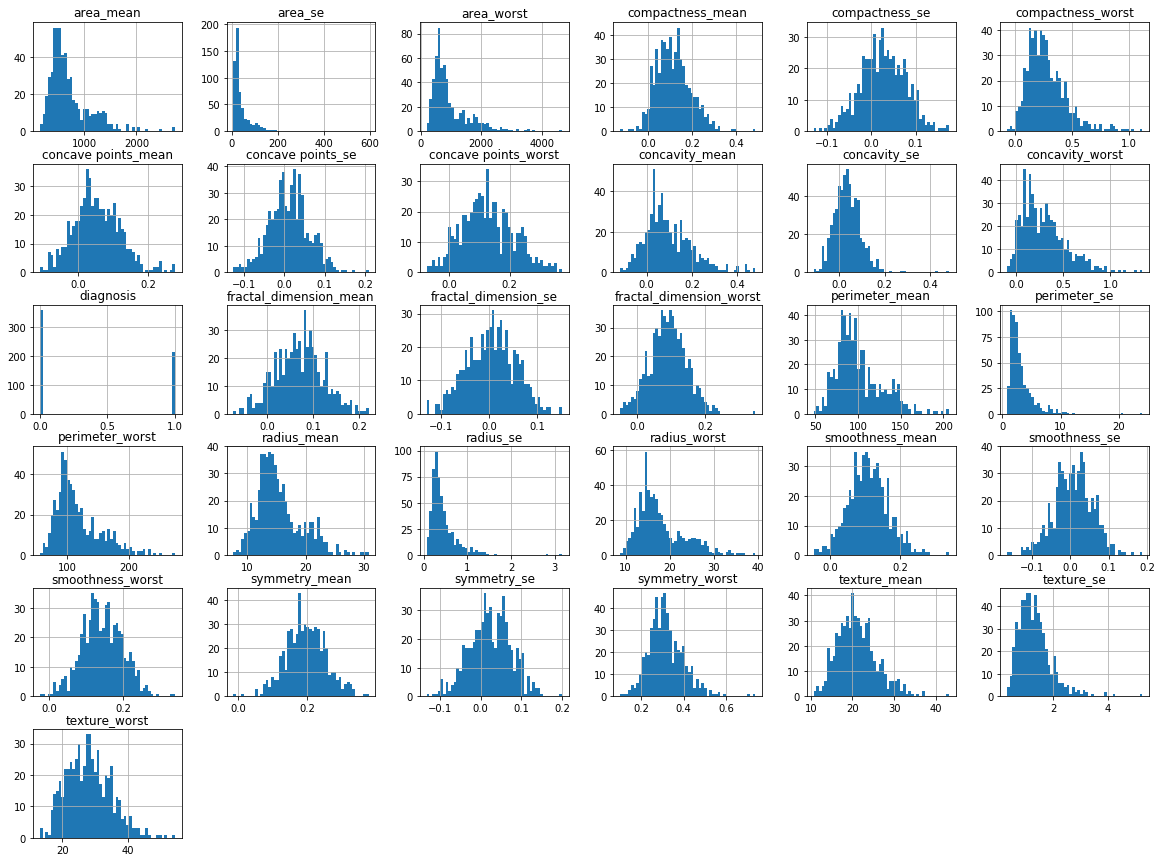

In [13]:
dropped_data.hist(bins=50, figsize = (20,15))
plt.show()

<b>Observations:</b>

The scale of the data is varying a lot. For example area ranges from 0 to 2000 and smoothness ranges from 0 to 0.2. I will standardize the data to scale the features similarly.

Some of the features are normally distributed but a lot of the features are tail heavy. A lot of the SE features are right skewed data. For the sake of simplicity I first standardized all features and ran a model.

The features all seem very reasonable - they don't have any strange peaks or obvious outliers in them.

<b>Heatmaps to see correlation of features

Features like area, perimeter and radius will clearly be correlated with each other as they are all dependant on radius. I wanted to see if any other features are heavily correlated with each other.

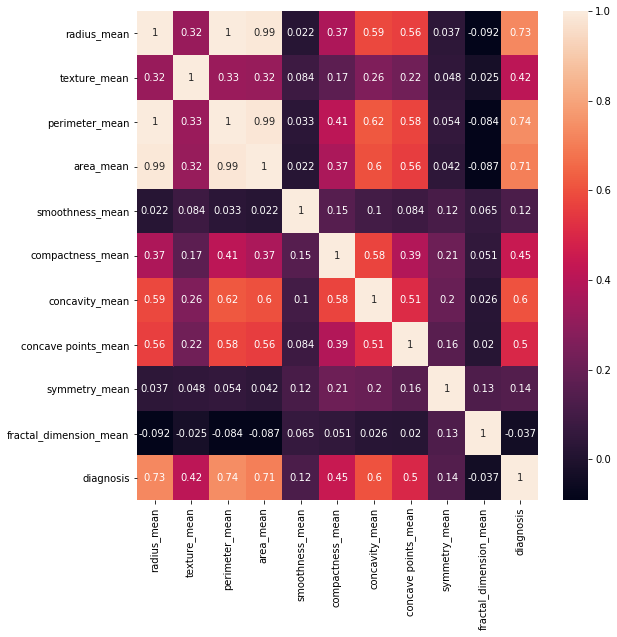

In [14]:
plt.figure(figsize=(9,9)) 
sns.heatmap(dropped_data.iloc[:,list(range(10)) + [-1]].corr(),cbar=True,yticklabels=True,annot=True)

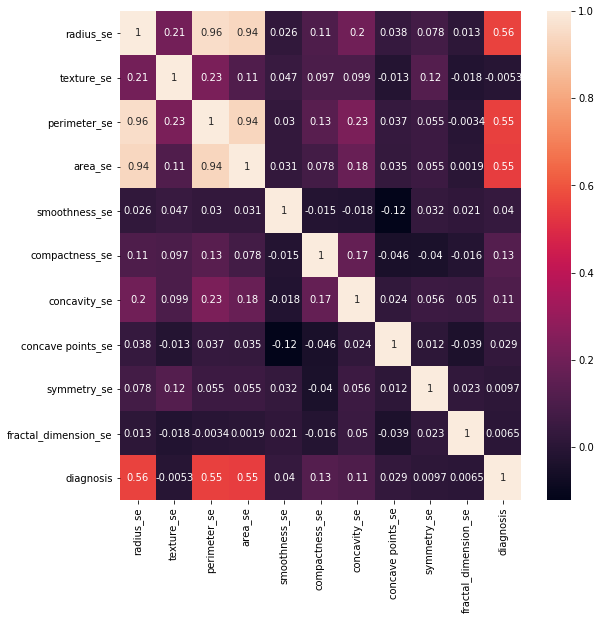

In [15]:
plt.figure(figsize=(9,9)) 
sns.heatmap(dropped_data.iloc[:,list(range(10,20)) + [-1]].corr(),cbar=True,yticklabels=True,annot=True)

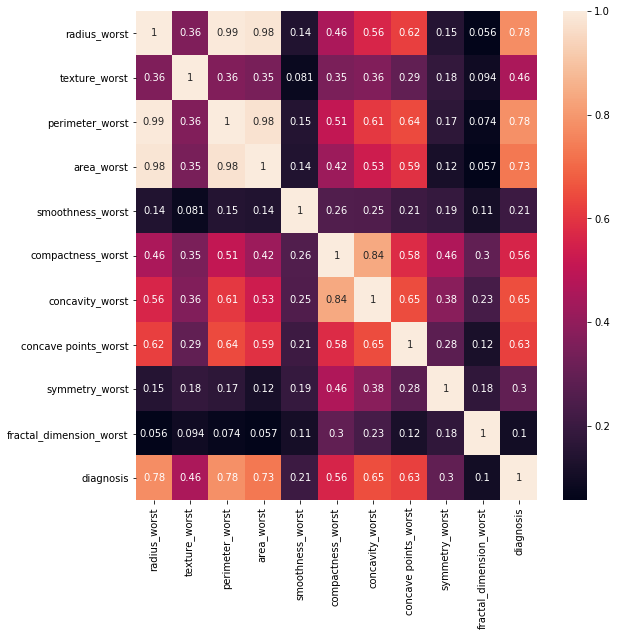

In [16]:
plt.figure(figsize=(9,9)) 
sns.heatmap(dropped_data.iloc[:,20:].corr(),cbar=True,yticklabels=True,annot=True)

The area, perimeter and radius features are highly positively correlated with each other as they are all dependant on radius value. I'm going to drop perimeter because it's almost 100% correlated to the radius. Regularization will also help in handling the area/radius correlation.

I also added diagnosis to all the correlation plots to observe how it's correlated with all the other features. Radius seems to be a highly correlated feature with diagnosis.

In [17]:
data = data.drop(['perimeter_mean', 'perimeter_se', 'perimeter_worst'], axis = 1)

<b>Pairplot visualization

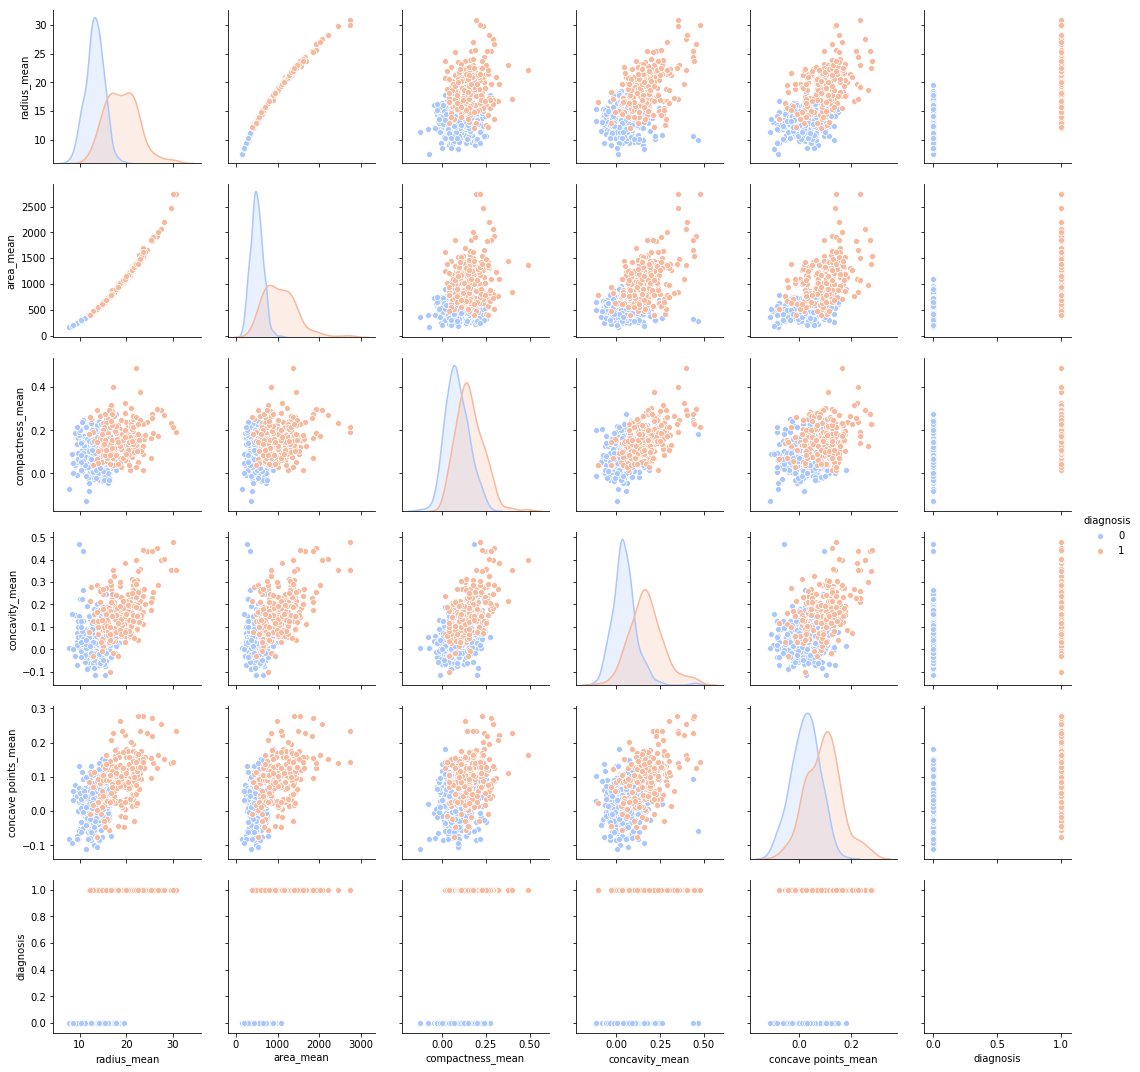

In [18]:
data_for_corr = dropped_data[['radius_mean', 'area_mean', 'compactness_mean',
                              'concavity_mean', 'concave points_mean', 'diagnosis']]
sns.pairplot(data_for_corr, palette = 'coolwarm', hue = 'diagnosis')

These pairplots give some nice insight into the mean features. The diagonal plots plot the two distributions of the two classes into a single graph for a single feature whereas all the other graphs are 2d plots with one feature against the other. Some clear separation can be seen between the two classes. The radius/perimeter/area plots are especially interesting in terms of how they separate the data. 

<b> Conclusion of EDA </b> 

1. Standardization of the features is required
2. All the features have information that can be used to separate the classes
3. Some values are NaN and need to be imputed
4. Some of the features are highly correlated (area, perimeter, radius) and I dropped the perimeter feature

<b>Standardizing data</b>

I started with scaling the features and imputing missing values using median. I chose median because there are very few missing values and from the visualizations of the data most of them have a high peak (frequently repeated values).

In [52]:
num_pipeline = Pipeline([
                        ('imputer', Imputer(strategy='median')),
                        ('std_scaler', StandardScaler())
])
#skip the index and diagnosis (data already has perimeter features dropped)
X = num_pipeline.fit_transform(data.iloc[:,1:-1])
y = data.diagnosis

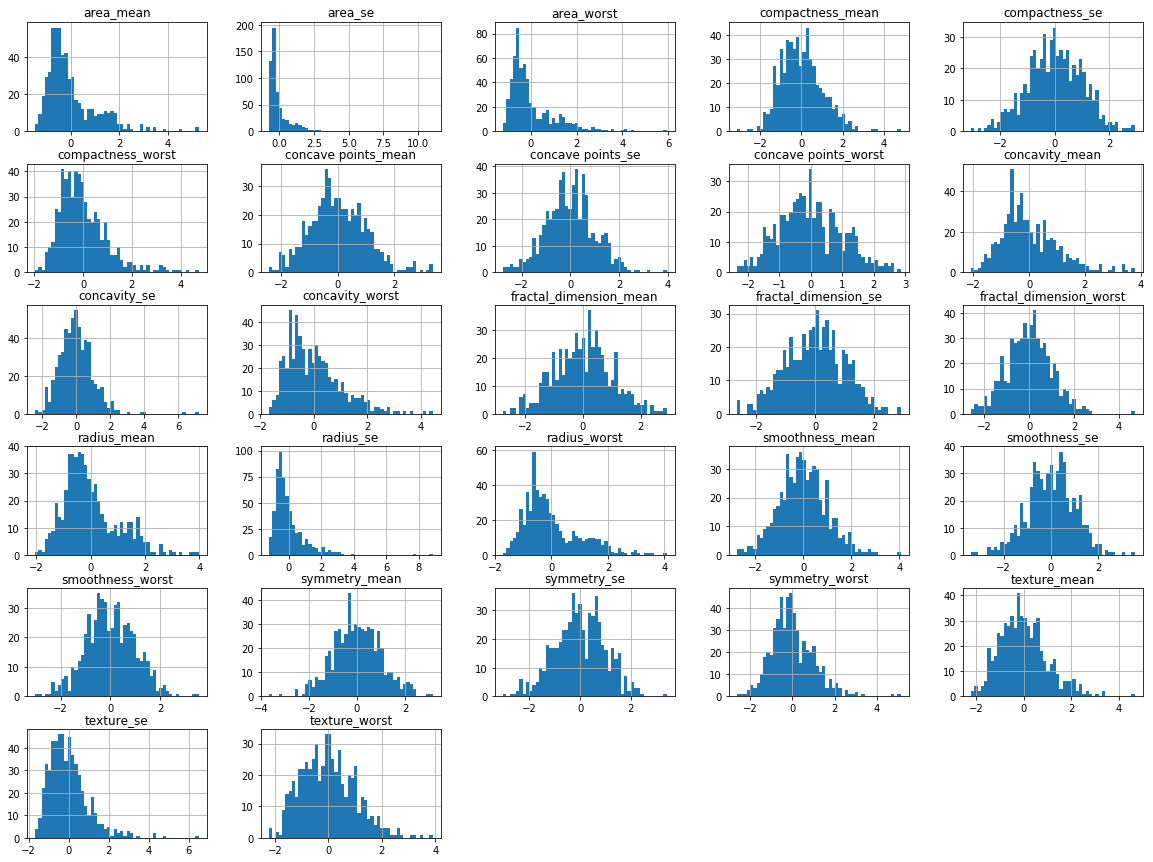

In [20]:
colnames = list(data.iloc[:,1:-1].columns)
pd.DataFrame(X,  columns=colnames).hist(bins=50, figsize = (20,15))
plt.show()

The features now all have a similar scale.

<b>PCA</b>

PCA is used to reduce the dimensionality of a dataset and it can also be used to handle correlated features. I could use it to handle the correlated features of area/perimeter/radius but I don't think PCA is required for the given dataset. The number of features is low and the trade-off when using PCA is a loss of interpretability of what the features are after doing PCA. I still used PCA below for visualization purposes. Even when preserving 99.9% of the variance 2 features are being dropped which tells me that there is some high correlation present between features in this dataset. I then used TSNE to visualize the reduced data in 2 dimensions.

Shape of data before PCA (569, 27)
Shape of Reduced Data:  (569, 25)


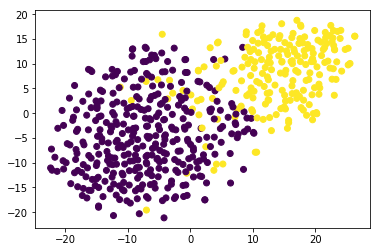

In [21]:
"""
Perform PCA (Principal Component Analysis) in order reduce the dimensionality of the data to print out the 
dimensionally reduced data (2D Data)and use TSNE to visualize the same. I do the PCA on the entire training dataset
after standarization.
"""

pca = PCA(n_components = 0.999) #build the model
reduced_data = pca.fit_transform(X) #reduce the data, output is ndarray
print("Shape of data before PCA", X.shape)
print("Shape of Reduced Data: ", reduced_data.shape) #inspect shape of the `reduced_data`
#Plot the data reduced to 2 dimensions using TSNE with PCA
tsne = TSNE(init = 'pca')
tsne_plot = tsne.fit_transform(X)
plt.scatter(tsne_plot[:, 0], tsne_plot[:,1], c = y)
plt.show()

Even in just 2 dimensions the data is quite separable!

<b> Test, train, split</b>

Okay, I have a nice dataset with unimportant features dropped out. Before using the data, let's (stratified) split into test and training set and let's forget the test set throughout our model building. The provided test data does not have labels so I created my own test dataset for model validation purposes.

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for train_index, test_index in split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Function that I will use to plot a confusion matrix

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


<h2>Model Training</h2>

<b>Logistic Regression</b>

The model I selected as a simple baseline is logistic regression. I chose this model due its speed, simplicity and explainability for a classification problem. I use a randomidzed search for the hyperparameter tuning.

In [24]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
lr = LogisticRegression()
random_search_lr = RandomizedSearchCV(lr, param_grid, scoring = 'recall')
random_search_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='recall', verbose=0)

In [25]:
cvres = random_search_lr.cv_results_
res = (pd.DataFrame(cvres).sort_values(by='mean_test_score',ascending = False))[["mean_test_score","mean_train_score","params"]]
pd.concat([res['mean_test_score'],res["mean_train_score"],res['params'].apply(pd.Series)],axis=1)

,mean_test_score,mean_train_score,C,penalty
3,0.947122,0.967681,1.00,l2
6,0.941196,0.941210,0.10,l1
0,0.935335,1.000000,10.00,l1
9,0.935335,0.988201,10.00,l2
8,0.929474,1.000000,1000.00,l2
1,0.917752,1.000000,1000.00,l1
4,0.917752,1.000000,100.00,l1
5,0.917687,0.944134,0.10,l2
7,0.905900,0.920587,0.01,l2
2,0.888121,0.888190,0.01,l1


The results are surprisingly good for the logistic regression. A mean 95% recall is very good! This means that we have very few false negatives using this model (people who have cancer labelled as not having cancer). I then save the best hyper-parameters.

In [26]:
best_lr_model = random_search_lr.best_estimator_.fit(X_train, y_train)

<b>XGBoost</b>

Since this is a matter of life and death I did not stop exploring models at logistic (even though it has a very good performance) 

I try XGBoost because of it's unreasonable effectiveness at classification. It is a highly performative gradient boosted machine. It's a tree based method so it can pick up non-linearities in the data. Logistic is a linear method so perhaps it's missing out some information and XGBoost will perform better

In [34]:
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.4, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.3, 0.7),
              'min_child_weight': [1, 2, 3]
             }
grid_search_xg = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'recall', error_score = 0, verbose = 0, n_jobs = -1,cv=5)

grid_search_xg.fit(X_train,y_train)
best_xgboost_model = grid_search_xg.best_estimator_.fit(X_train, y_train)

It takes considerably longer to train the model than the logistic regression did (9s vs 10ms). However inference time will be just as fast as logistic.

<h2>Metrics</h2>

In [28]:
def print_metrics(clf, X, y):
    y_pred = clf.predict(X)
    plot_confusion_matrix(y, y_pred, [0,1])
    print ("Precision: ", precision_score(y, y_pred))
    print ("Recall: ", recall_score(y, y_pred))

<b> Confusion matrices on training data </b>

Confusion matrix
[[281   4]
 [  5 165]]
Precision:  0.9763313609467456
Recall:  0.9705882352941176


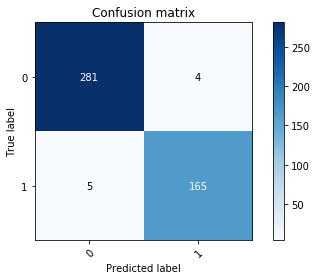

In [35]:
print_metrics(best_lr_model, X_train, y_train)

Confusion matrix
[[285   0]
 [  2 168]]
Precision:  1.0
Recall:  0.9882352941176471


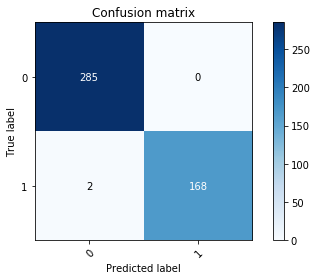

In [36]:
print_metrics(best_xgboost_model, X_train, y_train)

Both models have very low false negative rates however, XGBoost has very low false negative rate on the training data.

<b>Learning Curve</b>

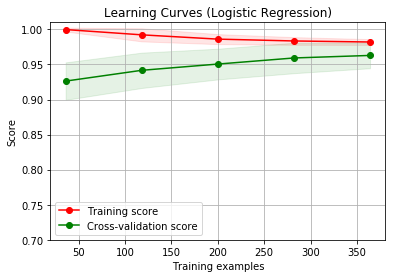

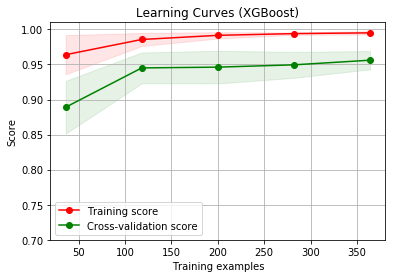

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = best_lr_model
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (XGBoost)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = best_xgboost_model
plot_learning_curve(estimator, title, X_train, y_train, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

The learning curves inform us that both the models are neither overfitting (test and train have similar scores) or underfitting (high scores)

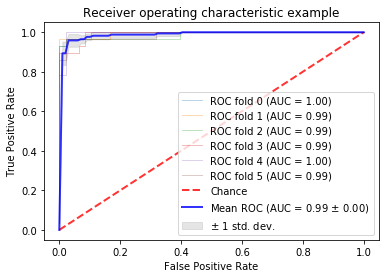

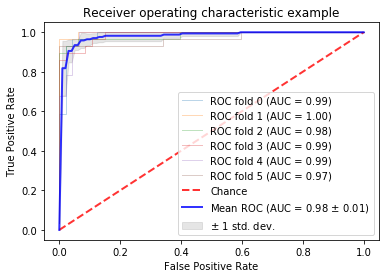

In [38]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Classification and ROC analysis
# Run classifier with cross-validation and plot ROC curves
def plot_roc(classifier, X, y):
    cv = StratifiedKFold(n_splits=6)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(best_lr_model, X_train, np.array(y_train))
plot_roc(best_xgboost_model, X_train, np.array(y_train))

The AUROC (Area under ROC curve) is very high for both the models (approaching 1)

<h2>Final test evaluation</h2>

Finally I evaluate the two models on the unseen test data that I extracted in the first step.

Confusion matrix
[[72  0]
 [ 5 37]]
Precision:  1.0
Recall:  0.8809523809523809


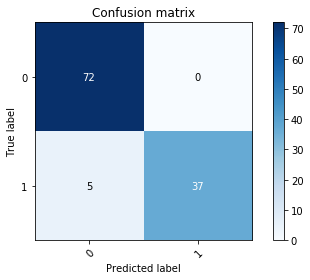

In [39]:
print_metrics(best_lr_model, X_test, y_test)

Confusion matrix
[[72  0]
 [ 5 37]]
Precision:  1.0
Recall:  0.8809523809523809


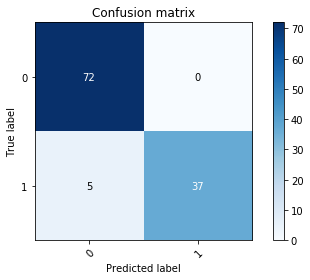

In [40]:
print_metrics(best_xgboost_model, X_test, y_test)

<b>Final test data prediction</b>

I finally chose the logistic regression model as it performs identically to the XGBoost model on the unseen test data and is simpler/faster/more interpretable.

In [45]:
test_data = pd.read_csv('test/Predict_these_cases.csv')
#skip index and diagnosis
test_data = test_data.drop(['perimeter_mean', 'perimeter_se', 'perimeter_worst'], axis = 1)
X_test = num_pipeline.fit_transform(test_data.iloc[:, 1:-1])

Sanity check to ensure test and train have the same schema

In [46]:
test_data.head()

,id,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,925923,12.554,26.245,442.030,0.197,0.147,0.091,0.024,0.207,0.057,0.233,3.162,18.631,0.062,0.087,0.022,-0.027,0.063,0.003,13.592,40.637,519.581,0.132,0.318,0.392,0.130,0.246,0.099,-
1,925924,15.368,29.758,657.910,0.140,0.201,-0.116,0.103,0.216,0.057,0.548,1.639,32.665,-0.021,0.082,0.041,-0.030,-0.034,-0.015,16.795,36.301,774.271,0.172,0.206,0.147,0.194,0.209,0.118,-
2,925943,12.339,32.185,422.852,0.040,0.065,-0.015,-0.060,0.143,0.031,0.440,4.190,25.013,0.007,-0.019,0.071,-0.007,0.024,-0.037,12.977,41.922,481.695,0.119,0.123,-0.009,0.029,0.155,0.109,-
3,926254,16.677,33.607,785.440,0.141,0.243,0.213,0.052,0.254,0.085,0.342,1.379,24.824,0.032,0.124,0.085,-0.070,0.019,-0.005,19.226,46.857,1002.439,0.184,0.901,1.278,0.281,0.489,0.154,-
4,926757,22.942,27.438,1475.716,0.152,0.249,0.358,0.130,0.254,0.088,1.009,1.143,130.149,-0.092,0.093,0.146,-0.008,0.020,0.010,26.535,32.227,1992.959,0.096,0.364,0.753,0.214,0.238,0.081,-


In [49]:
data.head()

,id,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842934,19.772,11.336,1096.771,0.067,0.326,0.385,0.221,0.217,0.099,1.243,0.979,168.133,0.024,0.077,0.017,-0.020,-0.004,0.035,27.839,19.029,2211.972,0.212,0.737,0.781,0.287,0.466,0.133,1
1,843149,22.601,19.453,1452.768,0.099,0.052,0.042,0.151,0.191,0.140,0.692,0.809,81.215,0.069,-0.004,0.038,-0.043,0.133,-0.027,27.368,25.600,2143.103,0.137,0.282,0.311,0.184,0.302,0.196,1
2,84301535,21.507,23.214,1317.998,0.111,0.266,0.241,0.197,0.166,0.081,0.779,0.852,103.117,-0.054,0.009,0.071,-0.038,-0.023,0.064,25.882,28.073,1872.370,0.119,0.395,0.459,0.300,0.361,0.126,1
3,84348933,12.505,22.374,423.055,0.275,0.252,0.280,0.107,0.250,0.120,0.524,1.282,29.843,-0.007,0.111,0.062,0.082,0.014,0.001,16.386,28.946,622.059,0.168,0.971,0.728,0.266,0.737,0.349,1
4,84359034,22.227,15.690,1420.916,-0.032,0.261,0.230,0.120,0.120,0.087,0.793,0.824,103.499,0.033,0.087,0.074,0.116,0.052,-0.079,24.687,18.287,1725.556,0.161,0.234,0.464,0.336,0.218,0.107,1


I can now make predictions using the given test data and assign it to the diagnosis column. I wrote the final data file into a csv file.

In [50]:
test_data.diagnosis = best_lr_model.predict(X_test)

In [51]:
test_data.to_csv('final_test_data.csv')

<b>QUESTIONS</b>

1. Please show all your work in Python Jupyter notebook.
> Done above.
2. Using data visualization tools, please explain how we can understand the data structure.
> Done above.
3. Please explain if dimensionality reduction is required/possible or not. How did you check?
> Done above in the PCA section
4. Please explain eigen-vectors and eigen-values and their importance.
> In PCA - the eigen-vectors determine the principal direction of the variance and the eigen-values are the magnitude of the variance - they are used to explain the variance in the data along the new principal component. T
5. Which classification methods are you using? How do you decide among different methods?
> I started with logistic regression because it is a simple and easily interepreted linear model used for classification. The results of logistic regression were so good that I did not really need to further explore any other methods. Since, the problem statement is related to the medical domain - the cost of false negatives could be human lives. So, in order to further reduce the amount of false negatives I tried XGBoost because it is a very fast and powerful tree based model. It did not however provide much improvement in performance so I chose to stick with my tuned logistic regression model as the final model due to its interpretability and simplicity.
6. Please provide confusion matrix and explain how it can help us to check reliability of result.
> It helps us check reliability in this case as we are not optimizing for accuracy but for the model have high precision and recall or as low false negatives as possible. 
7. Please provide the learning curve and explain how it can help us in determining whether the model is being over-fit or under-fit.
> The learning curves shown above inform us that the model is not over fitting (test and train accuracies are similar) and it is not underfitting (all metrics are all very high)
8. When do you consider adding “regularization parameter” to the model? and how it will help to improve the model performance?
> I consider adding regularization to prevent the model from overfitting or becoming too complex. It improves the performance by simplifying the model which will allow it to generalize better on out of sample detection. 
9. Please briefly explain how reinforcement-learning can be utilized in fraud detection models.
> RL systems have an agent that works in an environment and performs some actions. In this case specifically the agent will act like a fraudster and perform an action (making a transaction) in the environment (banking system + fraud detection system). We can have the action result in a reward which is the transaction is accepted or rejected. In this way the agent will keep getting better at committing fraud and we can use this information to inform other models as to the optimal policy a fraudster would undergo to trick our fraud detection system.

10. Please describe when to use logistic sigmoid, tanh, and Fourier as basis function.
> Sigmoid is normally used as last layer for binary classification problems as it outputs a value constrained between 0 and 1. Hence it is used when we want to output a probability. It is also used sometimes in LSTMs however tanh is preferred in this case as it output ranges from (-1, +1) which allows for increases and decreases in the state which sigmoid would not allow for (0,1 constraint). Tanh is also said to be good at preventing the vanishing gradient problem which is found commonly in RNN/LSTM networks. Fourier transforms are usually used in image transformation domain. I see some research describing it being used in time series data as well as some kinds of convolution networks. However, it is doubtful to me as to where a fourier basis function would be used over sigmoid or tanh.